In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 

In [2]:
df=pd.read_csv('census.csv')
df.head()


,county,population,total_units,occupied_units,vacant_units
0,Adair,7496,3585,3217,368
1,Adams,3704,1888,1614,274
2,Allamakee,14061,7668,5797,1871
3,Appanoose,12317,6306,5320,986
4,Audubon,5674,2787,2498,289


In [3]:
#add in county number (index)

df['county_id']=np.arange(0, 99)

df.head()

,county,population,total_units,occupied_units,vacant_units,county_id
0,Adair,7496,3585,3217,368,0
1,Adams,3704,1888,1614,274,1
2,Allamakee,14061,7668,5797,1871,2
3,Appanoose,12317,6306,5320,986,3
4,Audubon,5674,2787,2498,289,4


In [4]:
#moves county index to first column
df.insert(0, 'county_id', df.pop('county_id'))

In [5]:
df.head()

,county_id,county,population,total_units,occupied_units,vacant_units
0,0,Adair,7496,3585,3217,368
1,1,Adams,3704,1888,1614,274
2,2,Allamakee,14061,7668,5797,1871
3,3,Appanoose,12317,6306,5320,986
4,4,Audubon,5674,2787,2498,289


In [6]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp')
shapefile_iowa.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,19064,10257,8472,335,17980,7652,9146,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,14023,6862,6940,221,13844,4678,8232,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861..."
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,8502,3385,4951,166,8617,2249,5877,491,4,"POLYGON ((-95.26926 43.25537, -95.26140 43.255..."
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,6483,2469,3911,103,6370,1662,4362,346,4,"POLYGON ((-95.20902 41.86371, -95.20890 41.863..."
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,9138,4806,4164,168,9129,3237,5317,575,1,"POLYGON ((-91.25080 42.64558, -91.25160 42.645..."


In [7]:
df1=df.copy()

#creating a dummy dataframe in order to append lat and long from shp to census dataframe
dummy=pd.DataFrame()
dummy['county']=shapefile_iowa['NAME10']

In [8]:
dummy['longitude']=shapefile_iowa['INTPTLON10']
dummy['latitude']=shapefile_iowa['INTPTLAT10']

In [9]:
#sorts the dummy df alphabetically wrt county name
dummy1=dummy.sort_values('county', ascending=True).copy()

In [10]:
df1['latitude']=dummy1['latitude']
df1['longitude']=dummy1['longitude']

In [11]:
df1.head()

,county_id,county,population,total_units,occupied_units,vacant_units,latitude,longitude
0,0,Adair,7496,3585,3217,368,+42.0416910,-092.9814523
1,1,Adams,3704,1888,1614,274,+42.0925474,-092.0576300
2,2,Allamakee,14061,7668,5797,1871,+43.0798220,-095.1497261
3,3,Appanoose,12317,6306,5320,986,+41.6790143,-095.3089173
4,4,Audubon,5674,2787,2498,289,+42.8409979,-091.3235108


In [19]:
shapefile_iowa.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   99 non-null     object  
 1   COUNTYFP10  99 non-null     object  
 2   GEOID10     99 non-null     int64   
 3   NAME10      99 non-null     object  
 4   NAMELSAD10  99 non-null     object  
 5   ALAND10     99 non-null     int64   
 6   AWATER10    99 non-null     int64   
 7   INTPTLAT10  99 non-null     object  
 8   INTPTLON10  99 non-null     object  
 9   TOTPOP      99 non-null     int64   
 10  NH_WHITE    99 non-null     int64   
 11  NH_BLACK    99 non-null     int64   
 12  NH_AMIN     99 non-null     int64   
 13  NH_ASIAN    99 non-null     int64   
 14  NH_NHPI     99 non-null     int64   
 15  NH_OTHER    99 non-null     int64   
 16  NH_2MORE    99 non-null     int64   
 17  HISP        99 non-null     int64   
 18  H_WHITE     99 non-null     int64   
 19  H_

In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   county_id       99 non-null     int64 
 1   county          99 non-null     object
 2   population      99 non-null     int64 
 3   total_units     99 non-null     int64 
 4   occupied_units  99 non-null     int64 
 5   vacant_units    99 non-null     int64 
 6   latitude        99 non-null     object
 7   longitude       99 non-null     object
dtypes: int64(5), object(3)
memory usage: 6.3+ KB


In [27]:
shapefile_IA=shapefile_iowa.sort_values('NAME10', ascending=True).copy()


In [29]:
shapefile_IA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99 entries, 65 to 9
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   99 non-null     object  
 1   COUNTYFP10  99 non-null     object  
 2   GEOID10     99 non-null     int64   
 3   NAME10      99 non-null     object  
 4   NAMELSAD10  99 non-null     object  
 5   ALAND10     99 non-null     int64   
 6   AWATER10    99 non-null     int64   
 7   INTPTLAT10  99 non-null     object  
 8   INTPTLON10  99 non-null     object  
 9   TOTPOP      99 non-null     int64   
 10  NH_WHITE    99 non-null     int64   
 11  NH_BLACK    99 non-null     int64   
 12  NH_AMIN     99 non-null     int64   
 13  NH_ASIAN    99 non-null     int64   
 14  NH_NHPI     99 non-null     int64   
 15  NH_OTHER    99 non-null     int64   
 16  NH_2MORE    99 non-null     int64   
 17  HISP        99 non-null     int64   
 18  H_WHITE     99 non-null     int64   
 19  H_

In [40]:
shapefile_IA['county_id']=np.arange(0, 99)

In [51]:
shapefile_IA['INTPTLAT10']=shapefile_IA['INTPTLAT10'].astype(float)
shapefile_IA['INTPTLON10']=shapefile_IA['INTPTLON10'].astype(float)


In [52]:
shapefile_IA.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry,county_id
65,19,001,19001,Adair,Adair County,1474404167,2597997,41.328528,-94.478164,7682,...,1790,2114,92,3811,1133,2461,217,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157...",0
58,19,003,19003,Adams,Adams County,1096700733,5353423,41.021656,-94.696906,4029,...,1028,1108,49,2106,565,1395,146,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158...",1
78,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,43.274964,-91.382751,14330,...,3553,3264,117,6923,2421,4093,409,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500...",2
34,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,40.744683,-92.870345,12887,...,2951,3161,133,6136,1814,4033,289,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812...",3
61,19,009,19009,Audubon,Audubon County,1147264459,1152260,41.679178,-94.904312,6119,...,1611,1802,44,3412,1080,2136,196,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688...",4


In [53]:
map_population_by_county_data = shapefile_IA.merge(df1, on='county_id')
# map_population_by_county_data = shapefile_IA.merge(df1, left_on='NAME10', right_on='county',suffixes=('_left', '_right'))
# map_population_by_county_data = shapefile_oregon.merge(population_by_county, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
county_populations = np.array(df1['population'])
state_population = sum(county_populations)
df1.sort_values('population', ascending=False).head()

,county_id,county,population,total_units,occupied_units,vacant_units,latitude,longitude
76,76,Polk,492401,210184,196891,13293,+40.9153392,-091.1869253
56,56,Linn,230299,101230,94751,6479,+42.3918601,-095.5074206
81,81,Scott,174669,77771,71628,6143,+42.8644496,-091.8393728
51,51,Johnson,152854,65916,61335,4581,+41.3307969,-092.6363663
6,6,Black Hawk,131144,58559,54223,4336,+42.3907681,-093.7091980


In [54]:
county_populations

array([  7496,   3704,  14061,  12317,   5674,  25575, 131144,  26715,
        24988,  20565,  20823,  14334,   9927,  20760,  13127,  18505,
        43127,  11658,  12012,   9748,  16384,  17043,  46460,  16525,
        99678,   9110,   7645,  17488,  38910,  17703,  99266,   9388,
        19509,  15627,  10019,   6605,   8771,  12329,  10623,  15039,
        10795,  16878,  14582,  20482,   9469,   9597,   7005,  16662,
        19485,  37813,  15663, 152854,  20646,  10033,  14828,  33555,
       230299,  10837,   8634,  11934,  16548,  22190,  33414,  40105,
        14484,  10565,   8751,   7577,  10330,  43235,  14182,   6192,
        15211,   8996,  25698,   7078, 492401,  93667,  18662,   4663,
         9814, 174669,  11746,  35872,  98537,  17135,   5896,  12138,
         7203,  35437,  52403,  22565,   6497,  36999,  10679,  20070,
       105941,   7443,  12943])

In [55]:
state_population

3190369

In [56]:
map_population_by_county_data

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,CD,geometry,county_id,county,population,total_units,occupied_units,vacant_units,latitude,longitude
0,19,001,19001,Adair,Adair County,1474404167,2597997,41.328528,-94.478164,7682,...,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157...",0,Adair,7496,3585,3217,368,+42.0416910,-092.9814523
1,19,003,19003,Adams,Adams County,1096700733,5353423,41.021656,-94.696906,4029,...,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158...",1,Adams,3704,1888,1614,274,+42.0925474,-092.0576300
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,43.274964,-91.382751,14330,...,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500...",2,Allamakee,14061,7668,5797,1871,+43.0798220,-095.1497261
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,40.744683,-92.870345,12887,...,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812...",3,Appanoose,12317,6306,5320,986,+41.6790143,-095.3089173
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,41.679178,-94.904312,6119,...,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688...",4,Audubon,5674,2787,2498,289,+42.8409979,-091.3235108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,19,189,19189,Winnebago,Winnebago County,1037261544,3182052,43.378124,-93.743488,10866,...,4,"POLYGON ((-93.97054 43.42971, -93.97053 43.430...",94,Winnebago,10679,5077,4512,565,+40.6475875,-091.4771574
95,19,191,19191,Winneshiek,Winneshiek County,1786750121,698598,43.292989,-91.850788,21056,...,1,"POLYGON ((-92.08001 43.42885, -92.08002 43.433...",95,Winneshiek,20070,8916,8170,746,+42.0375379,-093.4660934
96,19,193,19193,Woodbury,Woodbury County,2147483647,12793293,42.393220,-96.053296,102172,...,4,"POLYGON ((-96.41112 42.38606, -96.41128 42.386...",96,Woodbury,105941,42701,39904,2797,+42.4033232,-092.7902613
97,19,195,19195,Worth,Worth County,1036314948,4709127,43.373491,-93.248533,7598,...,1,"POLYGON ((-93.37877 43.25537, -93.38055 43.255...",97,Worth,7443,3480,3127,353,+41.3401835,-095.5449053


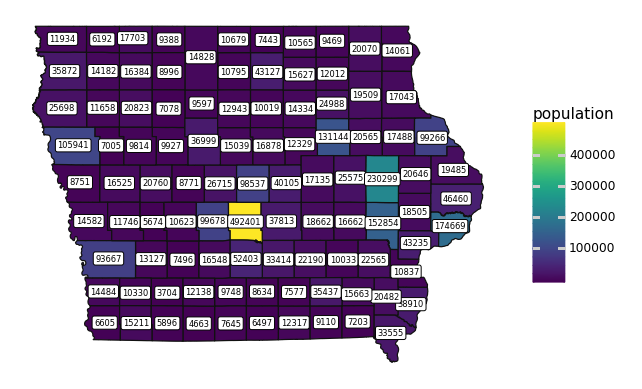

<ggplot: (377959022)>

In [58]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='INTPTLON10', y='INTPTLAT10', 
                     label='population',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

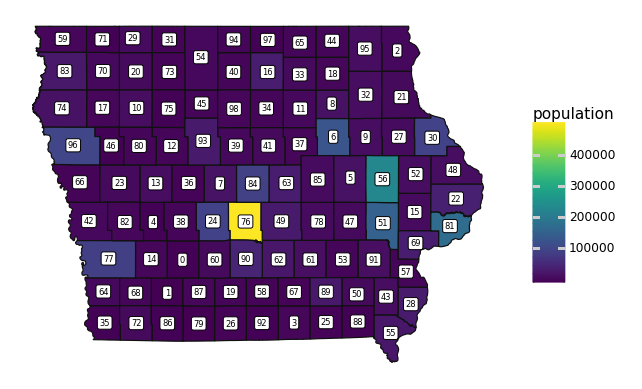

<ggplot: (378588028)>

In [59]:
map_by_county_id = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='INTPTLON10', y='INTPTLAT10', 
                     label='county_id',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_by_county_id